# 数据探索性分析

In [1]:
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = 'all' #默认为'last'

import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams['axes.unicode_minus'] = False  
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']

In [2]:
DATA_PATH = "./Raw Data/"
USERS_DATA_PATH = DATA_PATH + "users.csv"
VENUES_DATA_PATH = DATA_PATH + "venues.csv"
SOCIAL_DATA_PATH = DATA_PATH + "socialgraph.csv"
RATINGS_DATA_PATH = DATA_PATH + "ratings.csv"
CHECKINS_DATA_PATH = DATA_PATH + "checkins.csv"

# 记录每个文件读取时的dtype
all_dtypes = {}

## 减少内存占用

In [3]:
# reduce_mem_usage 函数通过调整数据类型，帮助我们减少数据在内存中占用的空间
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            elif str(col_type)[:8] == 'datetime':
                pass
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

## 打卡数据探索

### 读取用户打卡数据

In [4]:
#设置chunksize参数，来控制每次迭代数据的大小
checkins_data = pd.DataFrame()
chunker = pd.read_csv(CHECKINS_DATA_PATH,chunksize=500000)
for item in chunker:
    checkins_data = checkins_data.append(item)

In [5]:
checkins_data

,id,user_id,venue_id,latitude,longitude,created_at
0,16,539270,1206,41.878114,-87.629798,2011-12-08 05:08:42
1,17,1330941,1206,0.000000,0.000000,2011-12-08 04:32:19
2,18,1330942,1206,0.000000,0.000000,2011-12-08 04:29:38
3,19,282798,1206,41.878114,-87.629798,2011-12-08 04:26:06
4,20,376793,1206,41.878114,-87.629798,2011-12-08 04:17:50
...,...,...,...,...,...,...
1021961,1021977,244608,11138,0.000000,0.000000,2012-04-23 01:47:05
1021962,1021978,2153502,783,0.000000,0.000000,2012-04-23 01:42:42
1021963,1021979,592192,82919,40.239812,-76.919974,2012-04-22 23:26:48
1021964,1021980,494946,68691,32.912624,-96.638883,2012-04-23 00:36:33


In [6]:
def clean_checkins_data(cdf):
    # 去除经纬度数据
    cdf = cdf.drop(['latitude','longitude'], axis=1)
    # 将object转为日期格式
    cdf['created_at'] = pd.to_datetime(cdf['created_at'])
    # 去重
    cdf = cdf.drop_duplicates(['user_id','venue_id','created_at'])
    
    return cdf

cdf = clean_checkins_data(checkins_data)
cdf = reduce_mem_usage(cdf)
types = dict(cdf.dtypes.map(lambda x: str(x)))
del types['created_at']
all_dtypes['checkins'] = types
cdf.to_csv('./Clean Data/checkins.csv', index=0)
print('清洗数据保存成功！')

Memory usage of dataframe is 40660160.00 MB
Memory usage after optimization is: 28462112.00 MB
Decreased by 30.0%
清洗数据保存成功！


In [7]:
cdf.dtypes

id                     int32
user_id                int32
venue_id               int32
created_at    datetime64[ns]
dtype: object

## 社交网络数据探索

### 读取数据社交网络数据

In [8]:
#设置chunksize参数，来控制每次迭代数据的大小
social_data = pd.DataFrame()
chunker = pd.read_csv(SOCIAL_DATA_PATH, chunksize=5000000)
for item in chunker:
    social_data = social_data.append(item)

C:\Users\USER\anaconda3\envs\JupyterLab-3\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
social_data

,first_user_id,second_user_id
0,1,10
1,10,1
2,1,11
3,11,1
4,1,12
...,...,...
27098485,venues,0
27098486,ratings,0
27098487,schema_migrations,0
27098488,(12 rows),0


In [10]:
def clean_social_data(sdf):
    # 去除尾部字段
    sdf = sdf[:-18]
    # 重新设置索引
    sdf.reset_index(drop=True, inplace=True)
    # 将类型转换成整数int
    sdf = sdf.astype('int64')
    # 去重
    sdf = sdf.drop_duplicates()
    
    return sdf

sdf = clean_social_data(social_data)
sdf = reduce_mem_usage(sdf)
all_dtypes['socialgraph'] = dict(sdf.dtypes.map(lambda x: str(x)))
sdf.to_csv('./Clean Data/socialgraph.csv', index=0)
print('清洗数据保存成功！')

Memory usage of dataframe is 428118048.00 MB
Memory usage after optimization is: 285412032.00 MB
Decreased by 33.3%
清洗数据保存成功！


### 分析每个节点的入度和出度

In [ ]:
G=nx.DiGraph()  #创建空的简单有向图
G.add_edges_from(sdf.values)   #添加边

In [13]:
def search_no_bothway(G):
    point_degree_difference = {}  # 入度-出度的差值
    for node in G.nodes():
        point_degree_difference[node] = G.in_degree(node) - G.out_degree(node)
            
    return point_degree_difference

In [14]:
point_degree_difference = search_no_bothway(G)

In [15]:
pd.DataFrame(sorted(point_degree_difference.items(), key=lambda x : x[1], reverse=True), columns=['node','difference'])

,node,difference
0,1562442,1
1,1562480,1
2,1,0
3,10,0
4,11,0
...,...,...
1880401,2090033,0
1880402,1764449,0
1880403,2146571,0
1880404,2146575,0


## 用户评分数据探索

### 读取用户评分数据

In [12]:
#设置chunksize参数，来控制每次迭代数据的大小
ratings_data = pd.DataFrame()
chunker = pd.read_csv(RATINGS_DATA_PATH,chunksize=1000000)
for item in chunker:
    ratings_data = ratings_data.append(item)

In [13]:
ratings_data

,user_id,venue_id,rating
0,1,1,5
1,1,51,4
2,1,51,2
3,1,51,5
4,1,52,5
...,...,...,...
2809575,2153498,91385,2
2809576,2153499,783,2
2809577,2153500,91385,2
2809578,2153501,68691,2


In [14]:
ratings_data['rating'].describe()

count    2.809580e+06
mean     3.515076e+00
std      1.275262e+00
min      2.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [15]:
rdf = reduce_mem_usage(ratings_data)
all_dtypes['ratings'] = dict(rdf.dtypes.map(lambda x: str(x)))
rdf.to_csv('./Clean Data/ratings.csv', index=0)
print('清洗数据保存成功！')

Memory usage of dataframe is 67430048.00 MB
Memory usage after optimization is: 25286348.00 MB
Decreased by 62.5%
清洗数据保存成功！


### 观察每个用户(评分数量占前95%)的评分

In [16]:
each_user_rating = pd.DataFrame(rdf.groupby('user_id').count()['rating'])

<AxesSubplot:ylabel='Count'>

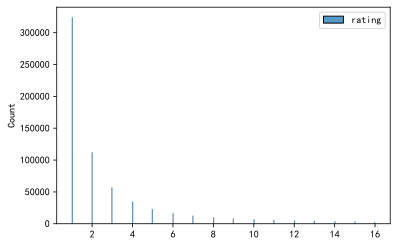

In [17]:
sns.histplot(each_user_rating.sort_values('rating').iloc[:int(each_user_rating.shape[0]*0.95),:])

### 观察每个地点(评分数量占95%)的评分数量

In [18]:
each_local_rating = pd.DataFrame(rdf.groupby('venue_id').count()['rating'])

<AxesSubplot:ylabel='Count'>

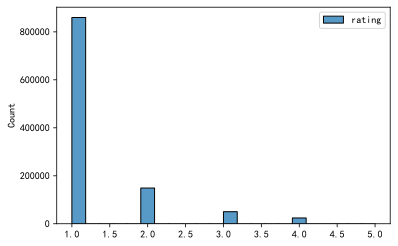

In [19]:
sns.histplot(each_local_rating.sort_values('rating').iloc[:int(each_local_rating.shape[0]*0.95),:])

## 用户和地点数据探索

### 读取用户和地点数据

In [16]:
#设置chunksize参数，来控制每次迭代数据的大小
users_data = pd.DataFrame()
chunker = pd.read_csv(USERS_DATA_PATH,chunksize=1000000)
for item in chunker:
    users_data = users_data.append(item)
    
venues_data = pd.DataFrame()
chunker = pd.read_csv(VENUES_DATA_PATH,chunksize=500000)
for item in chunker:
    venues_data = venues_data.append(item)

In [17]:
users_data

,id,latitude,longitude
0,1,45.072464,-93.455788
1,2,30.669682,-81.462592
2,3,43.549975,-96.700327
3,4,44.840798,-93.298280
4,5,27.949436,-82.465144
...,...,...,...
2153464,2153498,0.000000,0.000000
2153465,2153499,0.000000,0.000000
2153466,2153500,0.000000,0.000000
2153467,2153501,0.000000,0.000000


In [18]:
len(np.unique(users_data.id))==users_data.shape[0]

True

### 寻找“僵尸”id

In [19]:
active_id = np.unique(list(cdf.user_id)+list(sdf.first_user_id)+list(sdf.second_user_id)+list(rdf.user_id))
len(users_data.id)==len(active_id)
dead_id = pd.DataFrame(list(users_data.id)+list(active_id),columns=['dead_id']).drop_duplicates(keep=False)
dead_id

False

,dead_id
88178,88180
88359,88361
286218,286220
321956,321958
323214,323216
...,...
2152264,2152298
2152539,2152573
2152724,2152758
2153218,2153252


### 删除“僵尸”id

In [20]:
users_data = users_data[~users_data.id.isin([i[0] for i in list(dead_id.values)])]
users_data

,id,latitude,longitude
0,1,45.072464,-93.455788
1,2,30.669682,-81.462592
2,3,43.549975,-96.700327
3,4,44.840798,-93.298280
4,5,27.949436,-82.465144
...,...,...,...
2153464,2153498,0.000000,0.000000
2153465,2153499,0.000000,0.000000
2153466,2153500,0.000000,0.000000
2153467,2153501,0.000000,0.000000


In [21]:
# 去重
udf = users_data.drop_duplicates()
udf = reduce_mem_usage(udf)
all_dtypes['users'] = dict(udf.dtypes.map(lambda x: str(x)))
udf.to_csv('./Clean Data/users.csv', index=0)
print('清洗数据保存成功！')

Memory usage of dataframe is 68821184.00 MB
Memory usage after optimization is: 34410592.00 MB
Decreased by 50.0%
清洗数据保存成功！


In [26]:
venues_data

,id,latitude,longitude
0,1,44.882011,-93.212364
1,2,44.883169,-93.213687
2,3,44.883455,-93.214316
3,4,44.881387,-93.213801
4,5,44.882129,-93.214012
...,...,...,...
1143085,1143087,0.000000,0.000000
1143086,1143088,0.000000,0.000000
1143087,1143089,0.000000,0.000000
1143088,1143090,0.000000,0.000000


In [27]:
len(np.unique(venues_data.id))==venues_data.shape[0]

True

### 寻找“僵尸”地点

In [22]:
active_venues = np.unique(list(cdf.venue_id)+list(rdf.venue_id))
len(venues_data.id)==len(active_venues)
dead_venues = pd.DataFrame(list(venues_data.id)+list(active_venues),columns=['dead_venues']).drop_duplicates(keep=False)
dead_venues

False

,dead_venues
5,6
7,8
8,9
9,10
10,11
...,...
1143085,1143087
1143086,1143088
1143087,1143089
1143088,1143090


### 删除“僵尸”地点

In [23]:
venues_data = venues_data[~venues_data.id.isin([i[0] for i in list(dead_venues.values)])]
venues_data

,id,latitude,longitude
0,1,44.882011,-93.212364
1,2,44.883169,-93.213687
2,3,44.883455,-93.214316
3,4,44.881387,-93.213801
4,5,44.882129,-93.214012
...,...,...,...
1143042,1143044,40.600931,-111.822940
1143043,1143045,40.603130,-111.832723
1143044,1143046,0.000000,0.000000
1143070,1143072,38.154199,-75.405581


In [24]:
# 去重
vdf = venues_data.drop_duplicates()
vdf = reduce_mem_usage(vdf)
all_dtypes['venues'] = dict(vdf.dtypes.map(lambda x: str(x)))
vdf.to_csv('./Clean Data/venues.csv', index=0)
print('清洗数据保存成功！')

Memory usage of dataframe is 36495808.00 MB
Memory usage after optimization is: 18247904.00 MB
Decreased by 50.0%
清洗数据保存成功！


### 使用Google地图定位经纬度(0,0)的地点，发现其位于海洋上，并且有多个用户和地点的经纬度为(0,0)，故可以推断出其标志着该地点的经纬度信息缺失

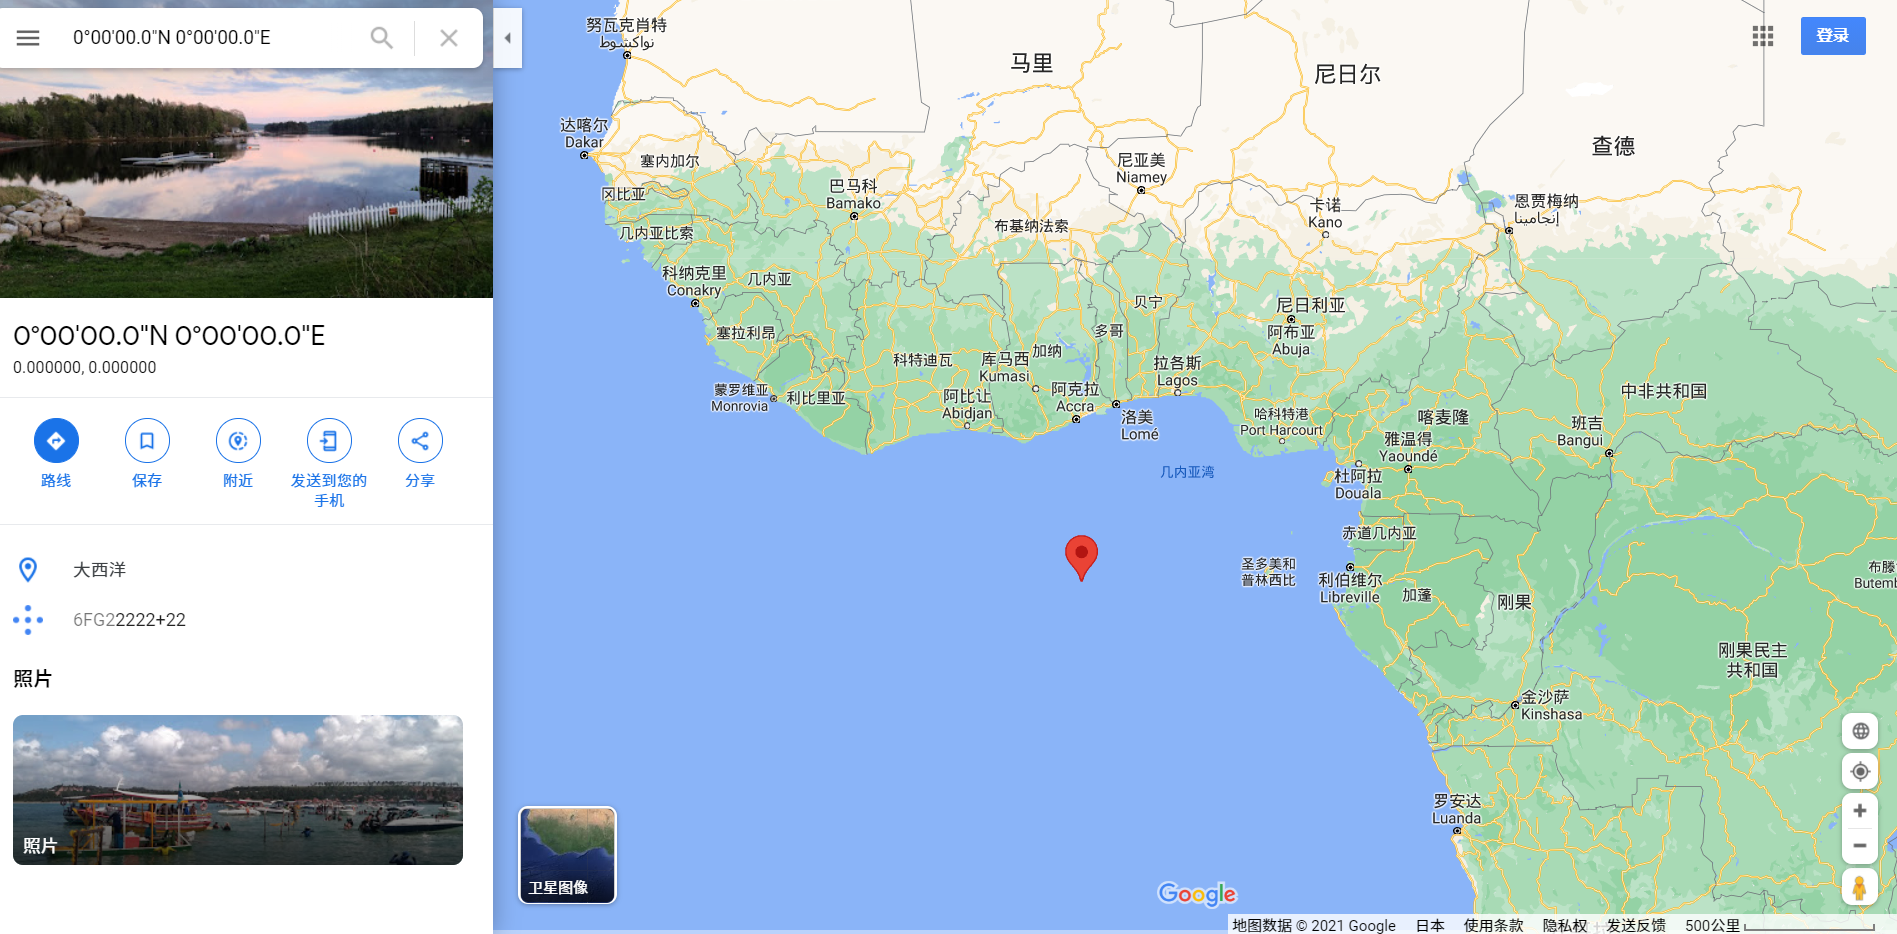

## 每个数据集的数据类型

In [25]:
all_dtypes

{'checkins': {'id': 'int32', 'user_id': 'int32', 'venue_id': 'int32'},
 'socialgraph': {'first_user_id': 'int32', 'second_user_id': 'int32'},
 'ratings': {'user_id': 'int32', 'venue_id': 'int32', 'rating': 'int8'},
 'users': {'id': 'int32', 'latitude': 'float16', 'longitude': 'float16'},
 'venues': {'id': 'int32', 'latitude': 'float16', 'longitude': 'float16'}}

## 读取清理完成的数据

In [37]:
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = 'all' #默认为'last'

import pandas as pd
import numpy as np
import networkx as nx
from geopy.distance import geodesic
import swifter
from statsmodels.distributions.empirical_distribution import ECDF
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams['axes.unicode_minus'] = False  
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']

In [38]:
CLEAN_DATA = "./Clean Data/"
CLEAN_USERS_DATA = CLEAN_DATA + 'users.csv'
CLEAN_VENUES_DATA = CLEAN_DATA + 'venues.csv'
CLEAN_RATINGS_DATA = CLEAN_DATA + 'ratings.csv'
CLEAN_SOCIALGRAPH_DATA = CLEAN_DATA + 'socialgraph.csv'
CLEAN_CHECKINS_DATA = CLEAN_DATA + 'checkins.csv'

all_dtypes = {'users': {'id': 'int32', 'latitude': 'float16', 'longitude': 'float16'},
 'venues': {'id': 'int32', 'latitude': 'float16', 'longitude': 'float16'},
 'socialgraph': {'first_user_id': 'int32', 'second_user_id': 'int32'},
 'ratings': {'user_id': 'int32', 'venue_id': 'int32', 'rating': 'int8'},
 'checkins': {'id': 'int32',
  'user_id': 'int32',
  'venue_id': 'int32'}}

In [39]:
udf = pd.read_csv(CLEAN_USERS_DATA, dtype=all_dtypes['users'])
vdf = pd.read_csv(CLEAN_VENUES_DATA, dtype=all_dtypes['venues'])
sdf = pd.read_csv(CLEAN_SOCIALGRAPH_DATA, dtype=all_dtypes['socialgraph'])
rdf = pd.read_csv(CLEAN_RATINGS_DATA, dtype=all_dtypes['ratings'])
cdf = pd.read_csv(CLEAN_CHECKINS_DATA, dtype=all_dtypes['checkins'], parse_dates=['created_at'])

### 构造社交网络

In [40]:
G=nx.DiGraph()  #创建空的简单有向图
G.add_nodes_from(udf.id)   #添加节点
G.add_edges_from(sdf.values)   #添加边

## 观察每个用户的整体数据

In [41]:
cnum = pd.DataFrame(cdf.groupby('user_id').id.count()).rename(columns={'id':'num_of_checkins'})
snum = pd.DataFrame(dict(G.degree).items(), columns=['user_id', 'num_of_friends']).set_index('user_id')\
                    .applymap(lambda x:int(x/2))
rnum = pd.DataFrame(rdf.groupby('user_id').rating.count()).rename(columns={'rating':'num_of_ratings'})

In [42]:
all_users_combine = udf.set_index('id').join(cnum).join(snum).join(rnum)
all_users_combine.fillna(0,inplace=True)
all_users_combine
all_users_combine.to_csv('./all_users_combine.csv')

,latitude,longitude,num_of_checkins,num_of_friends,num_of_ratings
id,,,,,
1,45.062500,-93.4375,6.0,29,32.0
2,30.671875,-81.4375,2.0,15,31.0
3,43.562500,-96.6875,0.0,2,40.0
4,44.843750,-93.3125,4.0,8,12.0
5,27.953125,-82.4375,3.0,72,24.0
...,...,...,...,...,...
2153498,0.000000,0.0000,1.0,0,1.0
2153499,0.000000,0.0000,1.0,0,1.0
2153500,0.000000,0.0000,1.0,0,1.0


## 空间影响

### 合并checkins、venues和users

In [43]:
cvdf = pd.merge(cdf, vdf, left_on='venue_id', right_on='id')
cvdf.drop(['id_x','id_y'], axis=1, inplace=True)
cvdf

,user_id,venue_id,created_at,latitude,longitude
0,539270,1206,2011-12-08 05:08:42,41.90625,-87.6875
1,1330941,1206,2011-12-08 04:32:19,41.90625,-87.6875
2,1330942,1206,2011-12-08 04:29:38,41.90625,-87.6875
3,282798,1206,2011-12-08 04:26:06,41.90625,-87.6875
4,376793,1206,2011-12-08 04:17:50,41.90625,-87.6875
...,...,...,...,...,...
1016499,2053426,649839,2012-04-23 00:25:25,33.37500,-112.0000
1016500,18737,296575,2012-04-23 01:06:49,33.62500,-111.8750
1016501,2046332,941464,2012-04-22 23:22:17,33.50000,-112.0000
1016502,2153443,243233,2012-04-23 01:16:16,40.25000,-111.6875


In [44]:
cvudf = pd.merge(cvdf, udf, left_on='user_id', right_on='id', suffixes=['_venue','_home'])
cvudf.drop(['id'], axis=1, inplace=True)
cvudf = cvudf.sort_values(by=['user_id','created_at'], ascending=[True,True]).reset_index(drop=True, inplace=False)
cvudf

,user_id,venue_id,created_at,latitude_venue,longitude_venue,latitude_home,longitude_home
0,1,51,2011-12-12 19:54:14,44.968750,-93.2500,45.0625,-93.4375
1,1,84329,2011-12-25 00:47:33,21.328125,-157.8750,45.0625,-93.4375
2,1,7489,2012-01-29 17:06:02,42.218750,-83.3750,45.0625,-93.4375
3,1,64,2012-01-29 22:56:11,44.875000,-93.1875,45.0625,-93.4375
4,1,60,2012-04-11 22:21:26,36.093750,-115.1250,45.0625,-93.4375
...,...,...,...,...,...,...,...
1016499,2153498,91385,2012-04-23 01:02:34,34.125000,-118.3750,0.0000,0.0000
1016500,2153499,783,2012-04-23 01:44:21,34.031250,-118.2500,0.0000,0.0000
1016501,2153500,91385,2012-04-22 23:10:54,34.125000,-118.3750,0.0000,0.0000
1016502,2153501,68691,2012-04-23 00:39:34,29.656250,-95.2500,0.0000,0.0000


### 计算每个地点与家的距离

In [45]:
cvudf['from_home'] = cvudf.swifter.apply(lambda x: geodesic((x['latitude_venue'],x['longitude_venue']),\
                                                    (x['latitude_home'],x['longitude_home'])).km, axis=1)

Dask Apply:   0%|          | 0/24 [00:00<?, ?it/s]

### 计算上一个地点与现在地点的距离

In [46]:
change_list = cvudf[(cvudf.user_id - cvudf.user_id.shift().fillna(1)) != 0].index
values = cvudf[['latitude_venue', 'longitude_venue']]
values = pd.merge(values,values.shift().fillna(0), left_index=True, right_index=True)
values.loc[change_list,['latitude_venue_y','longitude_venue_y']] = 0
cvudf['from_last'] = values.swifter.apply(lambda x: geodesic((x['latitude_venue_x'],x['longitude_venue_x']),\
                                                     (x['latitude_venue_y'],x['longitude_venue_y'])).km, axis=1)

Dask Apply:   0%|          | 0/24 [00:00<?, ?it/s]

### 赋予缺失值

In [47]:
data = cvudf.copy()
from_home_none_list = []
from_last_none_list = []

from_home_none_list.append(list(data[(data['latitude_venue']==0)&(data['longitude_venue']==0)].index))
from_home_none_list.append(list(data[(data['latitude_home']==0)&(data['longitude_home']==0)].index))
from_last_none_list.append(list(change_list))
from_last_none_list.append(list(data[(data['latitude_venue']==0)&(data['longitude_venue']==0)].index))
from_last_none_list.append(list(np.array(data[(data['latitude_venue']==0)&(data['longitude_venue']==0)].index)+1))

In [48]:
from_home_none_list = np.unique(sum(from_home_none_list,[]))
from_last_none_list = np.unique(sum(from_last_none_list,[]))

In [49]:
data.loc[from_home_none_list,'from_home'] = np.nan
data.loc[from_last_none_list,'from_last'] = np.nan
data.loc[0,'from_last'] = np.nan

In [50]:
data

,user_id,venue_id,created_at,latitude_venue,longitude_venue,latitude_home,longitude_home,from_home,from_last
0,1,51,2011-12-12 19:54:14,44.968750,-93.2500,45.0625,-93.4375,18.082837,NaN
1,1,84329,2011-12-25 00:47:33,21.328125,-157.8750,45.0625,-93.4375,6371.267374,6385.734543
2,1,7489,2012-01-29 17:06:02,42.218750,-83.3750,45.0625,-93.4375,870.485759,7195.440043
3,1,64,2012-01-29 22:56:11,44.875000,-93.1875,45.0625,-93.4375,28.690707,845.444425
4,1,60,2012-04-11 22:21:26,36.093750,-115.1250,45.0625,-93.4375,2079.552119,2090.682875
...,...,...,...,...,...,...,...,...,...
1016499,2153498,91385,2012-04-23 01:02:34,34.125000,-118.3750,0.0000,0.0000,NaN,NaN
1016500,2153499,783,2012-04-23 01:44:21,34.031250,-118.2500,0.0000,0.0000,NaN,NaN
1016501,2153500,91385,2012-04-22 23:10:54,34.125000,-118.3750,0.0000,0.0000,NaN,NaN
1016502,2153501,68691,2012-04-23 00:39:34,29.656250,-95.2500,0.0000,0.0000,NaN,NaN


In [51]:
data.from_home.describe()

count    1.001039e+06
mean     1.061684e+03
std      2.235003e+03
min      0.000000e+00
25%      9.188229e+00
50%      4.451824e+01
75%      1.214576e+03
max      1.949844e+04
Name: from_home, dtype: float64

In [52]:
data.from_last.describe()

count    531049.000000
mean        680.391042
std        1212.319668
min           0.000000
25%           1.731012
50%          18.086757
75%         974.091490
max       17440.825434
Name: from_last, dtype: float64

<AxesSubplot:>

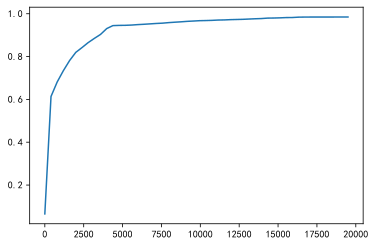

In [53]:
ecdf = ECDF(data.from_home)
x = np.linspace(data.from_home.min(), data.from_home.max())
y = ecdf(x)
sns.lineplot(x,y)

<AxesSubplot:>

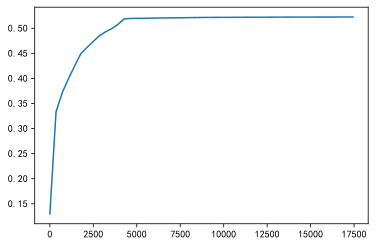

In [54]:
ecdf = ECDF(data.from_last)
x = np.linspace(data.from_last.min(), data.from_last.max())
y = ecdf(x)
sns.lineplot(x,y)

## 社交影响

In [55]:
def return_venues(df):
    return np.unique(df.venue_id)

location = cdf.groupby('user_id').apply(lambda x: return_venues(x))
location = pd.DataFrame(location, columns=['venues'])
location = location.applymap(lambda x: {'location':x})
node = pd.merge(udf, location, left_on='id', right_index=True)[['id','venues']]
node.reset_index(drop=True, inplace=True)

In [56]:
G=nx.DiGraph()  #创建空的简单有向图
G.add_nodes_from(node.values)   #添加节点
G.add_edges_from(sdf.values)   #添加边

### 找到社交圈最广的前10位

In [57]:
social_most_id=[idx for idx,_ in sorted(dict(G.degree).items(), key=lambda x : x[1], reverse=True)[:10]]

### 社交前10用户都没有checkins信息

In [58]:
cdf[cdf['user_id'].isin(social_most_id)]

,id,user_id,venue_id,created_at


### 找到社交圈最广的前100位

In [59]:
social_most_id=[idx for idx,_ in sorted(dict(G.degree).items(), key=lambda x : x[1], reverse=True)[:100]]

In [60]:
cdf[cdf['user_id'].isin(social_most_id)]

,id,user_id,venue_id,created_at
20544,20560,101,52313,2011-12-09 04:21:35
29982,30026,1897,817213,2011-12-09 14:37:42
185993,186218,3561,5222,2011-12-12 21:10:16
273240,274082,1977,180210,2011-12-23 21:33:45
344567,345722,5216,318048,2011-12-25 20:26:52
353819,354977,5216,60,2011-12-26 01:07:34
357443,358605,5216,7620,2011-12-26 03:01:08
364099,365269,485,183188,2011-12-26 07:41:41
379575,380751,1897,163578,2011-12-26 17:44:53
384596,385772,485,5222,2011-12-26 21:26:02


In [61]:
cvudf[cvudf['user_id'].isin(social_most_id)].to_csv('./social_most_checkins.csv',index=0)